
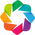

In [38]:
# Imports.
from g2p_client import G2PDatabase
from __future__ import division
import pandas as pd

import numpy as np
import sys
from itertools import product

import holoviews as hv
hv.extension('bokeh')
%matplotlib inline


In [42]:
# Constants
INDEX = 'associations'
HOST = 'dms-dev.compbio.ohsu.edu'
DATABASE = G2PDatabase(HOST, INDEX)
GENIE_VARIANTS = '/Users/goecksj/Downloads/data_mutations_extended_1.0.1.txt'
occurence_thres = 2
evidence_levels = ['A', 'B', 'C', 'D']
evidence_directions = ['resistant', 'responsive']

In [43]:
# Put G2P into a dataframe because this is the fastest way to work with it.
g2p_df = DATABASE.hits_to_dataframe(DATABASE.query_all())
g2p_df.groupby('source').size()

INFO:elasticsearch:GET http://elastic:9200/associations/_search?scroll=5m&size=1000 [status:200 request:0.417s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.148s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.164s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.084s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.156s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.195s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.106s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.182s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.183s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.192s]
INFO:elasticsearch:GET h

INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.192s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.155s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.179s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.214s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.141s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.435s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.198s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.157s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.235s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.244s]
INFO:elasticsearch:GET http://elastic:92

INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.228s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.245s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.188s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.348s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.237s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.240s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.359s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.279s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.383s]
INFO:elasticsearch:GET http://elastic:9200/_search/scroll?scroll=5m [status:200 request:0.224s]
INFO:elasticsearch:GET http://elastic:92

source
brca                       5717
cgi                        1432
civic                      3497
jax                        5754
jax_trials                 1173
molecularmatch             2079
molecularmatch_trials    199069
oncokb                     4048
pmkb                        609
sage                         69
dtype: int64

In [44]:
def get_num_donors(df):
    ''' Returns number of donors in a dataframe. '''
    return len(df['Tumor_Sample_Barcode'].unique())
    

def print_cohort_stats(df):
    print '-------------'
    print 'Number of variants: %i' % len(df)
    #print 'Number of unique variants: %i' % len(df[df['count'] > 1])
    print 'Number of donors: %i' % get_num_donors(df)
    print '-------------'

# Load GENIE variants.
genie_variants = pd.read_csv(GENIE_VARIANTS, sep='\t', comment='#')

print "All of GENIE"
print_cohort_stats(genie_variants)

# Count occurences for each variant and add a 'count' column.
variant_counts = genie_variants.groupby(['Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']).size().rename('count').reset_index()
genie_variants = pd.merge(genie_variants, variant_counts, on=['Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'])

print ''
print "GENIE filtered for variant count >= %i" % occurence_thres
print_cohort_stats(genie_variants[genie_variants['count'] >= occurence_thres])

# For later use:
num_variants = len(genie_variants)
num_donors = get_num_donors(genie_variants)
shared_variants = genie_variants[genie_variants['count'] >= occurence_thres]
num_shared_variants = len(shared_variants)
num_donors_with_shared_variants = get_num_donors(shared_variants)

All of GENIE
-------------
Number of variants: 110320
Number of donors: 17005
-------------

GENIE filtered for variant count >= 2
-------------
Number of variants: 40246
Number of donors: 14813
-------------


In [45]:
%%opts Bars [width=600]

# Look at distribution of variants across donors.
# NOTE: most donors have only 1 variant.
def histogram(dataframe, col, bins=50):
    hist, edges = np.histogram(dataframe.groupby([col]).size(), bins=bins)
    print hist
    print edges
    
    return hv.Bars((edges[0:-1], hist), kdims='x', vdims='y')
    
histogram(genie_variants, 'Tumor_Sample_Barcode', bins=range(1, 40))

[2963 2698 2276 1853 1495 1255  990  698  538  372  272  211  143  138  103
   80   62   54   63   56   44   41   32   24   23   20   20   21   23   22
    9   10   15    9   15   19   15   26]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


:Bars   [x]   (y)

In [46]:
# Group variants by source, evidence_label, and evidence_direction.
grouped_evidence_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'evidence_label']).size().rename('evidence_count').reset_index()
print "Raw number of mutations in G2P:", len(grouped_evidence_df)

# Remove entries without chromosome, start, ref, alt.
grouped_evidence_df = grouped_evidence_df[~(grouped_evidence_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_alt']).isin(['','None'])]
print "Number of complete mutations in G2P:", len(grouped_evidence_df)
sources = list(grouped_evidence_df['source'].unique())
print "Sources with viable mutations (%i):" % len(sources), ', '.join(sources)

# Create dataframe with single row per variant and evidence counts 
# as columns (e.g. 'civic_A' for evidence counts from CIVIC at level A).
new_data = []
for (chrom, start, ref, alt), df in grouped_evidence_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']):
    # Create base dictionary with all needed keys.
    d = {
        'chrom': chrom,
        'start': start,
        'ref': ref,
        'alt': alt,
    }
    keys = ['%s_%s' % (source, evidence_label) \
            for (source, evidence_label) in product(sources, evidence_levels)]
    d.update(dict.fromkeys(keys, 0))
    
    # Update entries based on evidence counts.
    for i, row in df.iterrows():
        d['%s_%s' % (row['source'], row['evidence_label'])] = row['evidence_count']
    new_data.append(d)
variant_ev_counts_df = pd.DataFrame(new_data).fillna(0)
variant_ev_counts_df = variant_ev_counts_df[['chrom', 'start', 'ref', 'alt'] + keys]
variant_ev_counts_df.head(100)

# Compute totals.

# Compute totals for source.
for source in sources:
    variant_ev_counts_df['total_source_%s' % (source)] = variant_ev_counts_df.filter(regex='^%s_' % (source)).sum(axis=1)

# Compute totals for levels.
for level in evidence_levels:
    variant_ev_counts_df['total_%s' % (level)] = variant_ev_counts_df.filter(regex='_%s$' % (level)).sum(axis=1)

# Compute totals for all using sources.
variant_ev_counts_df['total_source_total'] = variant_ev_counts_df.filter(regex='^total_source').sum(axis=1)
sources = sources + ['total']

pd.options.display.max_columns = None
variant_ev_counts_df.head()

Raw number of mutations in G2P: 9042
Number of complete mutations in G2P: 8264
Sources with viable mutations (8): civic, cgi, oncokb, molecularmatch, molecularmatch_trials, jax, jax_trials, brca


,chrom,start,ref,alt,civic_A,civic_B,civic_C,civic_D,cgi_A,cgi_B,cgi_C,cgi_D,oncokb_A,oncokb_B,oncokb_C,oncokb_D,molecularmatch_A,molecularmatch_B,molecularmatch_C,molecularmatch_D,molecularmatch_trials_A,molecularmatch_trials_B,molecularmatch_trials_C,molecularmatch_trials_D,jax_A,jax_B,jax_C,jax_D,jax_trials_A,jax_trials_B,jax_trials_C,jax_trials_D,brca_A,brca_B,brca_C,brca_D,total_source_civic,total_source_cgi,total_source_oncokb,total_source_molecularmatch,total_source_molecularmatch_trials,total_source_jax,total_source_jax_trials,total_source_brca,total_A,total_B,total_C,total_D,total_source_total
0,1,8073509,C,A,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,1,11169361,C,G,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
2,1,11174420,C,T,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,1,11177096,C,A,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3
4,1,11182158,A,C,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [47]:
# Annotate GENIE variants with evidence counts.
annotated_genie_variants = pd.merge(genie_variants, variant_ev_counts_df, how='left',
             left_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'],
             right_on=['chrom', 'start', 'ref', 'alt']).fillna(0)
shared_annotated_genie_variants = annotated_genie_variants[annotated_genie_variants['count'] >= occurence_thres]

In [48]:
%%opts Bars [title_format="GENIE non-unique variant coverage" xrotation=90, height=600 width=600]
%%opts Bars (color=Cycle('Spectral'))

# Print bar chart showing variant coverage of each source + total.
results_df = shared_annotated_genie_variants
data = [(source, 
         len(results_df[results_df['total_source_%s' % source] > 0]) / num_shared_variants * 100) \
         for source in sources]
data.sort(key=lambda tup: tup[1])
hv.Bars(data, kdims=[hv.Dimension('Source')], vdims=['Percent'])

:Bars   [Source]   (Percent)

In [49]:
%%opts Bars.Grouped [group_index=1 title_format="GENIE non-unique variant coverage by evidence level" height=600 width=600 legend_position='top']
%%opts Bars (color=Cycle('Spectral'))

# Print grouped bar chart showing variant coverage by source, evidence level.
results_df = shared_annotated_genie_variants
data = []
for (source, evidence_level) in product(sources, evidence_levels):
    source_el_counts = results_df.filter(regex='^%s_%s' % (source, evidence_level)).sum(axis=1)
    num_found = len(source_el_counts[source_el_counts > 0])/num_shared_variants * 100
    data.append( (source, evidence_level) + (num_found,) )
    
el_bars = hv.Bars(data, kdims=['Source', 'Evidence Level'], vdims=['Percent'])
el_bars.relabel(group='Grouped')

:Bars   [Source,Evidence Level]   (Percent)

In [50]:
%%opts Bars.Grouped [group_index=1 title_format="GENIE donor coverage by evidence level" height=600 width=600 legend_position='top']
%%opts Bars (color=Cycle('Spectral'))

# Print grouped bar chart showing donor coverage by source, evidence level.
results_df = shared_annotated_genie_variants
data = []
for (source, evidence_level) in product(sources, evidence_levels):
    variants = results_df[(results_df['%s_%s' % (source, evidence_level)] > 0)]
    donor_percent = get_num_donors(variants) / num_donors * 100
    data.append( (source, evidence_level) + (donor_percent,) )

el_bars = hv.Bars(data, kdims=['Source', 'Evidence Level'], vdims=['Percent'])
el_bars.relabel(group='Grouped')

:Bars   [Source,Evidence Level]   (Percent)

In [51]:
%%opts Bars.Grouped [group_index=1 title_format='GENIE coverage' height=600 width=600 legend_position='top']
%%opts Bars (color=Cycle('Category20') )

results_df = annotated_genie_variants

# Print bar chart with coverage by source + total.
data = []
for source in sources:
    variants_with_evidence = results_df[results_df['total_source_%s' % source] > 0]
    data.append( (source, 'All variants', len(variants_with_evidence)/num_variants * 100) )
    shared_variants_with_evidence = results_df[(results_df['total_source_%s' % source] > 0) & (results_df['count'] > 2)]
    data.append( (source, 'Non-unique variants', len(shared_variants_with_evidence)/num_shared_variants * 100) )
    data.append( (source, 'Donors', get_num_donors(variants_with_evidence)/num_donors * 100) )
    data.append( (source, 'Donors with non-unique variants', get_num_donors(shared_variants_with_evidence)/num_donors_with_shared_variants * 100) )
    
bars = hv.Bars(data, kdims=['Source', 'Metric'], vdims=['Percent'])
bars.relabel(group='Grouped')

:Bars   [Source,Metric]   (Percent)

In [52]:
# Are there variants in g2p which do not appear in GENIE?

# All g2p variants
grouped_evidence_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'evidence_label']).size().rename('evidence_count').reset_index()

# g2p variants with genomic locus
grouped_evidence_df = grouped_evidence_df[~(grouped_evidence_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_alt']).isin(['','None'])]


annotated_g2p_variants = pd.merge(grouped_evidence_df, genie_variants, how='left',
             left_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt'],
             right_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']).fillna(0)

g2p_not_genie = annotated_g2p_variants[annotated_g2p_variants['Start_Position'].isin([0, '', 'None'])].reset_index()

# Number of variants in g2p that is not in GENIE
print 'Number of variants in g2p: %i' % len(grouped_evidence_df)
print 'Number of variants in g2p that are not in GENIE: %i' % len(g2p_not_genie)

pd.options.display.max_columns = None
g2p_not_genie.head()

Number of variants in g2p: 8264
Number of variants in g2p that are not in GENIE: 6964


,index,feature_chromosome,feature_start,feature_ref,feature_alt,source,evidence_label,evidence_count,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND_VEP,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,flanking_bps,variant_id,variant_qual,ExAC_AF_Adj,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,count
0,0,1,8073509,C,A,civic,C,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
1,2,1,11174420,C,T,cgi,C,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
2,22,1,11184580,G,A,civic,D,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
3,23,1,11187094,G,T,civic,C,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
4,24,1,11187094,G,T,civic,D,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0


In [53]:
# Which sources have variants not in GENIE?
new = g2p_not_genie.groupby(['source']).size().rename('count').reset_index()
new.head()

,source,count
0,brca,5623
1,cgi,219
2,civic,235
3,jax,269
4,jax_trials,41
